In [1]:
import os, json, gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy.stats import boxcox
from scipy.signal import resample

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error

import lightgbm as lgb
import optuna

In [2]:
datapath = "../data"

train = sio.loadmat(os.path.join(datapath, "train.mat"))
test = sio.loadmat(os.path.join(datapath, "test.mat"))
reference = sio.loadmat(os.path.join(datapath, "reference.mat"))

print(
f"""Keys
train: {train.keys()}
test : {test.keys()}
ref  : {reference.keys()}
"""
)

Keys
train: dict_keys(['__header__', '__version__', '__globals__', '0001', '0002', '0003', '0004'])
test : dict_keys(['__header__', '__version__', '__globals__', '0001', '0002', '0003', '0004'])
ref  : dict_keys(['__header__', '__version__', '__globals__', '0005'])



In [4]:
feature_name = ['TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 'ST R',
                'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L']

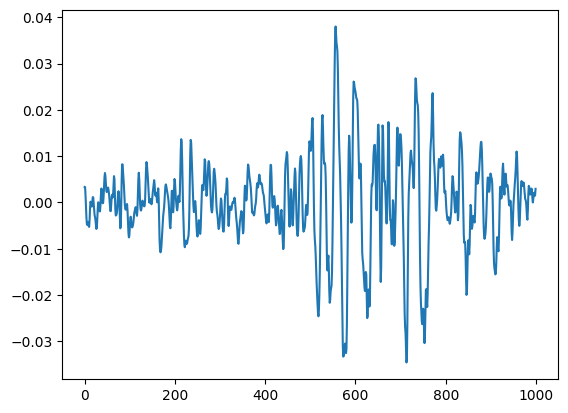

In [5]:
plt.plot(train["0001"][0][0][0][0, 0, :])

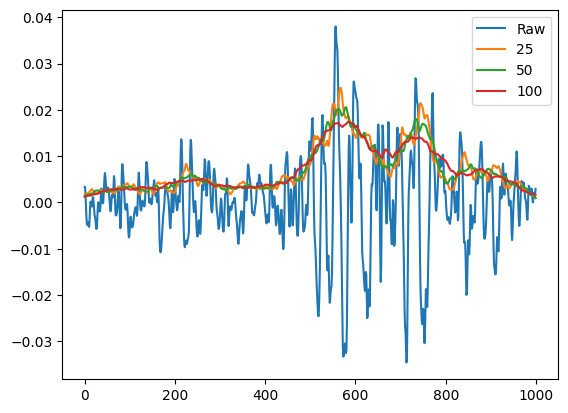

In [6]:
def moveRMS(data, window=25) -> np.ndarray:
    return np.convolve(np.sqrt(data**2), np.ones(window)/window, mode="same")

plt.plot(train["0001"][0][0][0][0, 0, :], label="Raw")
plt.plot(moveRMS(train["0001"][0][0][0][0, 0, :], window=25), label="25")
plt.plot(moveRMS(train["0001"][0][0][0][0, 0, :], window=50), label="50")
plt.plot(moveRMS(train["0001"][0][0][0][0, 0, :], window=100), label="100")
plt.legend()

In [8]:
sample_vels = train["0001"][0][0][1]

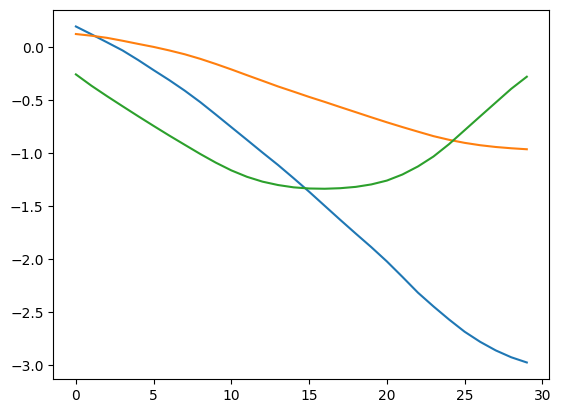

In [9]:
for i in range(3):
    plt.plot(sample_vels[0, i, :])

# データの前処理

In [67]:
emg_sampling = 2000
acc_sampling = 60
sampling_gap = emg_sampling // acc_sampling
num_lag_features = 6

train_df = []
for data_key in ["0001", "0002", "0003", "0004"]:
    # x(説明変数のデータフレーム作成)
    x_array = train[data_key][0][0][0]
    y_array = train[data_key][0][0][1]
    
    # (320, 1000, 16) (trial, timepoints, feature) 形式にする
    x_array = x_array.transpose(0, 2, 1)
    y_array = y_array.transpose(0, 2, 1)
    
    # 移動二条平均平方根により処理
    x_array = np.apply_along_axis(moveRMS, axis=1, arr=x_array)

    print(f"{data_key} length: {y_array.shape[0]*y_array.shape[1]}")
    # 全ユーザーの筋電位データと速度データをデータフレームにする
    user_df = []
    for ind, (x_arr, y_arr) in enumerate(zip(x_array, y_array)):
        
        feature_df = pd.DataFrame(y_arr, columns=["vel_x", "vel_y", "vel_z"])

        # sample_train_df[feature_name] = x_arr[sampling_gap::sampling_gap, :]
        for i in range(len(y_arr)):
            _x_arr = x_arr[sampling_gap*i:sampling_gap*(i+1), :]
            for j in range(num_lag_features):
                feature_df.loc[i, [f"{col}_lag{j}" for col in feature_name]] = _x_arr[j, :]
        
        # # 後処理のためにtrialsも情報として追加します
        feature_df["trials"] = ind+1
        user_df.append(feature_df)
    
    user_df = pd.concat(user_df).reset_index(drop=True)
    # 後処理のためにuser_idも情報として追加します
    user_df["user_id"] = data_key
    
    # append
    train_df.append(user_df)
    
    print(f"{data_key} Done!")
    del user_df
    gc.collect()

train_df = pd.concat(train_df).reset_index(drop=True)

train_df.to_csv(os.path.join(datapath, "processed/train_df.csv"), index=False)

0001 length: 9570
0001 Done!
0002 length: 9000
0002 Done!
0003 length: 9600
0003 Done!
0004 length: 9600
0004 Done!


In [44]:
emg_sampling = 2000
acc_sampling = 60
sampling_gap = emg_sampling // acc_sampling
num_lag_features = 6

sample_train_df = pd.DataFrame(y_arr, columns=["vel_x", "vel_y", "vel_z"])

# sample_train_df[feature_name] = x_arr[sampling_gap::sampling_gap, :]
for i in range(len(y_arr)):
    _x_arr = x_arr[sampling_gap*i:sampling_gap*(i+1), :]
    for j in range(num_lag_features):
        sample_train_df.loc[i, [f"{col}_lag{j}" for col in feature_name]] = _x_arr[j, :]
sample_train_df.head()

,vel_x,vel_y,vel_z,TA R_lag0,TA L_lag0,LG R_lag0,LG L_lag0,RF R_lag0,RF L_lag0,VL R_lag0,...,VL R_lag5,VL L_lag5,ST R_lag5,ST L_lag5,GMAX R_lag5,GMAX L_lag5,EMI R_lag5,EMI L_lag5,DEL R_lag5,DEL L_lag5
0,-0.440328,0.003913,-0.433672,0.000591,0.002189,0.011246,0.002628,0.012810,0.010531,0.029964,...,0.033916,0.125830,0.016251,0.076955,0.005099,0.009717,0.024935,0.003688,0.015260,0.002685
1,-0.534136,0.012748,-0.520288,0.002149,0.007089,0.096397,0.011147,0.028313,0.013051,0.078866,...,0.053052,0.011335,0.013136,0.047702,0.015960,0.018112,0.025161,0.002587,0.006753,0.023068
2,-0.628840,0.022840,-0.603308,0.001929,0.012447,0.021888,0.013043,0.032522,0.010977,0.027171,...,0.024191,0.055035,0.009832,0.061719,0.009941,0.028309,0.013366,0.006152,0.013516,0.006891
3,-0.721791,0.028201,-0.681598,0.003400,0.012487,0.042524,0.005812,0.045968,0.017581,0.030398,...,0.043261,0.108997,0.009810,0.036572,0.002979,0.043422,0.008108,0.003962,0.044049,0.009663
4,-0.809784,0.031882,-0.754223,0.003583,0.004118,0.015112,0.013662,0.027238,0.013614,0.048289,...,0.045930,0.031235,0.017342,0.062748,0.006803,0.016555,0.030785,0.017767,0.014863,0.015371


In [45]:
train_df

,vel_x,vel_y,vel_z,TA R_lag0,TA L_lag0,LG R_lag0,LG L_lag0,RF R_lag0,RF L_lag0,VL R_lag0,...,ST R_lag5,ST L_lag5,GMAX R_lag5,GMAX L_lag5,EMI R_lag5,EMI L_lag5,DEL R_lag5,DEL L_lag5,trials,user_id
0,0.193272,0.122026,-0.258740,0.001835,0.002641,0.014867,0.004060,0.006116,0.002942,0.026806,...,0.022757,0.001316,0.005847,0.001968,0.035646,0.013745,0.001970,0.012766,1,0001
1,0.119459,0.106136,-0.365619,0.002528,0.001661,0.017812,0.004540,0.021194,0.006424,0.030960,...,0.031349,0.001278,0.013171,0.011612,0.027550,0.019381,0.001700,0.012013,1,0001
2,0.043996,0.086143,-0.463906,0.001991,0.001694,0.033408,0.002443,0.022297,0.015539,0.050719,...,0.035823,0.001287,0.011870,0.009220,0.009943,0.053327,0.002164,0.056764,1,0001
3,-0.032592,0.058638,-0.558836,0.003447,0.002434,0.031631,0.003214,0.030248,0.010240,0.036009,...,0.066997,0.002234,0.011886,0.004652,0.010570,0.048711,0.001815,0.021893,1,0001
4,-0.122659,0.029072,-0.652777,0.002734,0.000880,0.022257,0.004501,0.053578,0.007497,0.073320,...,0.048702,0.001521,0.020394,0.003257,0.008335,0.018421,0.002252,0.012478,1,0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37765,-3.091058,-0.115931,-0.511953,0.005323,0.031530,0.070679,0.031552,0.016038,0.012004,0.015931,...,0.008955,0.132320,0.001923,0.026314,0.013909,0.005203,0.040862,0.081408,320,0004
37766,-3.131792,-0.152035,-0.455613,0.007059,0.024826,0.022313,0.018198,0.009019,0.004880,0.006028,...,0.002932,0.016196,0.002733,0.023094,0.034942,0.003105,0.018750,0.019805,320,0004
37767,-3.154251,-0.186714,-0.381268,0.009850,0.020750,0.006143,0.019395,0.038112,0.005492,0.008907,...,0.009583,0.093634,0.001988,0.035172,0.058199,0.002447,0.013781,0.005679,320,0004
37768,-3.152731,-0.198442,-0.269258,0.007804,0.010428,0.015496,0.012168,0.020743,0.013196,0.008953,...,0.028700,0.174167,0.005625,0.009428,0.024891,0.006960,0.016571,0.007503,320,0004


In [68]:
%%time

test_df = []
for data_key in ["0001", "0002", "0003", "0004"]:    
    # x(説明変数)のデータフレーム作成
    x_array = test[data_key][0][0][0]
    
    # (320, 1000, 16) (trial, time, feature) 形式にする
    x_array = x_array.transpose(0, 2, 1)
    
    # 移動二乗平均平方根により平滑化
    x_array = np.apply_along_axis(moveRMS, axis=1, arr=x_array)
    print(f"{data_key} length: {x_array.shape[0]*30}")
    
    user_df = []
    # 全ユーザーの筋電位データと速度データをデータフレームにする
    for ind, x_arr in enumerate(x_array):
        feature_df = pd.DataFrame(y_arr, columns=["vel_x", "vel_y", "vel_z"])

        # sample_train_df[feature_name] = x_arr[sampling_gap::sampling_gap, :]
        for i in range(len(y_arr)):
            _x_arr = x_arr[sampling_gap*i:sampling_gap*(i+1), :]
            for j in range(num_lag_features):
                feature_df.loc[i, [f"{col}_lag{j}" for col in feature_name]] = _x_arr[j, :]
        
        # trialsも情報として追加します
        feature_df["trials"] = ind+1
        user_df.append(feature_df)
    
    user_df = pd.concat(user_df).reset_index(drop=True)
    # user_idも情報として追加します
    user_df["user_id"] = data_key
    
    # append
    test_df.append(user_df)
    
    print(f"{data_key} Done!")
    del user_df
    gc.collect()

test_df = pd.concat(test_df).reset_index(drop=True)
test_df.to_csv(os.path.join(datapath, "processed/test_df.csv"))

0001 length: 9570
0001 Done!
0002 length: 9000
0002 Done!
0003 length: 9600
0003 Done!
0004 length: 9600
0004 Done!
CPU times: user 6min 3s, sys: 803 ms, total: 6min 4s
Wall time: 6min 5s


In [47]:
test_df

,vel_x,vel_y,vel_z,TA R_lag0,TA L_lag0,LG R_lag0,LG L_lag0,RF R_lag0,RF L_lag0,VL R_lag0,...,ST R_lag5,ST L_lag5,GMAX R_lag5,GMAX L_lag5,EMI R_lag5,EMI L_lag5,DEL R_lag5,DEL L_lag5,trials,user_id
0,-0.440328,0.003913,-0.433672,0.005069,0.000916,0.002179,0.027879,0.057633,0.030697,0.024111,...,0.015075,0.002247,0.005159,0.001988,0.006780,0.033108,0.005280,0.001327,1,0001
1,-0.534136,0.012748,-0.520288,0.016945,0.001629,0.003340,0.107837,0.069409,0.083250,0.023573,...,0.071923,0.001616,0.005593,0.003683,0.031598,0.029367,0.011043,0.002976,1,0001
2,-0.628840,0.022840,-0.603308,0.011813,0.001322,0.024284,0.047696,0.056393,0.018490,0.066085,...,0.114653,0.001607,0.008694,0.001461,0.026740,0.031968,0.004164,0.005069,1,0001
3,-0.721791,0.028201,-0.681598,0.013311,0.002291,0.049438,0.048189,0.043094,0.012289,0.023938,...,0.012878,0.009000,0.010764,0.002591,0.015502,0.032942,0.006580,0.004329,1,0001
4,-0.809784,0.031882,-0.754223,0.006150,0.002295,0.068209,0.017189,0.051573,0.029944,0.061135,...,0.008071,0.001603,0.014625,0.003319,0.029727,0.026685,0.014791,0.004008,1,0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37765,-3.091058,-0.115931,-0.511953,0.003123,0.033450,0.020283,0.022137,0.017755,0.005290,0.152807,...,0.045464,0.005475,0.038740,0.002202,0.022134,0.019216,0.013224,0.002552,320,0004
37766,-3.131792,-0.152035,-0.455613,0.004298,0.014620,0.028381,0.014332,0.012664,0.035210,0.096694,...,0.034000,0.003231,0.047085,0.002125,0.008103,0.024893,0.009925,0.001976,320,0004
37767,-3.154251,-0.186714,-0.381268,0.003666,0.035396,0.021572,0.035007,0.008826,0.013113,0.150548,...,0.021407,0.001532,0.033092,0.008944,0.015263,0.044989,0.008673,0.002648,320,0004
37768,-3.152731,-0.198442,-0.269258,0.005553,0.039216,0.015920,0.014509,0.019713,0.022806,0.083804,...,0.014441,0.002497,0.052250,0.013518,0.011397,0.027146,0.019328,0.003421,320,0004


# モデルの訓練

In [83]:
train_df = pd.read_csv(os.path.join(datapath, "processed/train_df.csv"), index_col=None)
test_df = pd.read_csv(os.path.join(datapath, "processed/test_df.csv"), index_col=0)

In [84]:
test_df.columns

Index(['vel_x', 'vel_y', 'vel_z', 'TA R_lag0', 'TA L_lag0', 'LG R_lag0',
       'LG L_lag0', 'RF R_lag0', 'RF L_lag0', 'VL R_lag0',
       ...
       'ST R_lag5', 'ST L_lag5', 'GMAX R_lag5', 'GMAX L_lag5', 'EMI R_lag5',
       'EMI L_lag5', 'DEL R_lag5', 'DEL L_lag5', 'trials', 'user_id'],
      dtype='object', length=101)

In [85]:
test_df

,vel_x,vel_y,vel_z,TA R_lag0,TA L_lag0,LG R_lag0,LG L_lag0,RF R_lag0,RF L_lag0,VL R_lag0,...,ST R_lag5,ST L_lag5,GMAX R_lag5,GMAX L_lag5,EMI R_lag5,EMI L_lag5,DEL R_lag5,DEL L_lag5,trials,user_id
0,-0.440328,0.003913,-0.433672,0.005069,0.000916,0.002179,0.027879,0.057633,0.030697,0.024111,...,0.015075,0.002247,0.005159,0.001988,0.006780,0.033108,0.005280,0.001327,1,1
1,-0.534136,0.012748,-0.520288,0.016945,0.001629,0.003340,0.107837,0.069409,0.083250,0.023573,...,0.071923,0.001616,0.005593,0.003683,0.031598,0.029367,0.011043,0.002976,1,1
2,-0.628840,0.022840,-0.603308,0.011813,0.001322,0.024284,0.047696,0.056393,0.018490,0.066085,...,0.114653,0.001607,0.008694,0.001461,0.026740,0.031968,0.004164,0.005069,1,1
3,-0.721791,0.028201,-0.681598,0.013311,0.002291,0.049438,0.048189,0.043094,0.012289,0.023938,...,0.012878,0.009000,0.010764,0.002591,0.015502,0.032942,0.006580,0.004329,1,1
4,-0.809784,0.031882,-0.754223,0.006150,0.002295,0.068209,0.017189,0.051573,0.029944,0.061135,...,0.008071,0.001603,0.014625,0.003319,0.029727,0.026685,0.014791,0.004008,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37765,-3.091058,-0.115931,-0.511953,0.003123,0.033450,0.020283,0.022137,0.017755,0.005290,0.152807,...,0.045464,0.005475,0.038740,0.002202,0.022134,0.019216,0.013224,0.002552,320,4
37766,-3.131792,-0.152035,-0.455613,0.004298,0.014620,0.028381,0.014332,0.012664,0.035210,0.096694,...,0.034000,0.003231,0.047085,0.002125,0.008103,0.024893,0.009925,0.001976,320,4
37767,-3.154251,-0.186714,-0.381268,0.003666,0.035396,0.021572,0.035007,0.008826,0.013113,0.150548,...,0.021407,0.001532,0.033092,0.008944,0.015263,0.044989,0.008673,0.002648,320,4
37768,-3.152731,-0.198442,-0.269258,0.005553,0.039216,0.015920,0.014509,0.019713,0.022806,0.083804,...,0.014441,0.002497,0.052250,0.013518,0.011397,0.027146,0.019328,0.003421,320,4


In [86]:
# 使用する特徴量を定義します
# x_columns = ['TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 'ST R',
#              'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L']

x_columns = test_df.columns
x_columns = x_columns.drop(["user_id", "vel_x", "vel_y", "vel_z"])

# 目的変数のカラムを定義します
y_columns = ["vel_x", "vel_y", "vel_z"]

kfold = GroupKFold(n_splits=5)

# lightgbmのハイパーパラメータの設定
params = {
    'objective': 'regression_l2',
    'metric':'rmse',
    'max_depth': -1,
    'learning_rate': 0.01,
    'seed': 777,
    'force_col_wise': True,
    "verbose": -1
}

In [87]:
# 重心加速度x,y,zそれぞれの回帰モデルを作成する
for target in y_columns:
    print(target)
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = x_columns
    
    oof = np.zeros(len(train_df))
    for i, (train_index, valid_index) in enumerate(kfold.split(train_df[x_columns], train_df[target], groups=train_df["trials"])):
        # lightgbmの学習・評価
        lg_train = lgb.Dataset(train_df.loc[train_index, x_columns], label=train_df.loc[train_index, target])
        lg_valid = lgb.Dataset(train_df.loc[valid_index, x_columns], label=train_df.loc[valid_index, target])
        model = lgb.train(params, lg_train, 10000, valid_sets = [lg_train, lg_valid],
                        callbacks=[lgb.early_stopping(stopping_rounds=500, verbose=False), lgb.log_evaluation(1000)])
        
        predict = model.predict(train_df.loc[valid_index, x_columns])
            
        feature_importance[f'importance'] = model.feature_importance()

        print(f"RMSE: {np.sqrt(mean_squared_error(train_df.loc[valid_index, target], predict))}")

        oof[valid_index] = predict
        
        # テストデータでの予測
        test_df[f"{target}_predict{i+1}"] = model.predict(test_df[x_columns])
    
    # クロスバリデーション全体で評価した結果の平均をとります
    train_df[f"{target}_oof"] = oof
    y_true, y_pred = train_df[target], train_df[f"{target}_oof"]
    
    # ここの評価指標をオリジナルのものに変える?
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    
    # 特徴重要度の可視化(チュートリアルではオフにしております)
    # plt.figure(figsize=(12, 8))
    # sns.barplot(data=feature_importance.sort_values(by='importance', ascending=False), x='importance', y='feature');
    # plt.title('50 TOP feature importance');
    # plt.show()

vel_x
[1000]	training's rmse: 1.38903	valid_1's rmse: 1.85559
[2000]	training's rmse: 1.20561	valid_1's rmse: 1.84326
[3000]	training's rmse: 1.07839	valid_1's rmse: 1.83959
[4000]	training's rmse: 0.989208	valid_1's rmse: 1.83468
[5000]	training's rmse: 0.91005	valid_1's rmse: 1.83225
RMSE: 1.8318007693472196
[1000]	training's rmse: 1.44237	valid_1's rmse: 1.67659
[2000]	training's rmse: 1.25395	valid_1's rmse: 1.67417
RMSE: 1.6686177066676577
[1000]	training's rmse: 1.42297	valid_1's rmse: 1.74752
RMSE: 1.7410340848471453
[1000]	training's rmse: 1.39426	valid_1's rmse: 1.8421
[2000]	training's rmse: 1.2196	valid_1's rmse: 1.83064
[3000]	training's rmse: 1.09339	valid_1's rmse: 1.82334
[4000]	training's rmse: 0.997651	valid_1's rmse: 1.82049
[5000]	training's rmse: 0.923587	valid_1's rmse: 1.81832
RMSE: 1.8177847892331882
[1000]	training's rmse: 1.43663	valid_1's rmse: 1.74736
[2000]	training's rmse: 1.25146	valid_1's rmse: 1.74053
[3000]	training's rmse: 1.12032	valid_1's rmse: 1.731

# 評価

In [88]:
scores = []
for user_id, group1 in train_df.groupby("user_id"):
    error_list = []
    for trial, group2 in group1.groupby("trials"):
        # numpyに変換して、transposeで(速度ベクトル, time)に変換すると元データに戻せる
        y_t = group2[["vel_x", "vel_y", "vel_z"]].to_numpy()
        # 予測用
        y_p = group2[["vel_x_oof", "vel_y_oof", "vel_z_oof"]].to_numpy()
        
        trial_rmse = np.sqrt(((y_t-y_p)**2).sum(axis=1).mean())
        
        error_list.append(trial_rmse)
    print(f"{user_id} rmse_3d mean: {np.mean(error_list)}")
    scores.append(np.mean(error_list))
print(f"RMSE_3D Mean: {np.mean(scores):.5f}")

1 rmse_3d mean: 1.850382816282863
2 rmse_3d mean: 1.8936941801965168
3 rmse_3d mean: 2.007283766528073
4 rmse_3d mean: 1.7210769268012087
RMSE_3D Mean: 1.86811


In [89]:
# 各fold毎の予測結果を平均します
test_df["vel_x_predict"] = test_df[["vel_x_predict1", "vel_x_predict2", "vel_x_predict3", "vel_x_predict4", "vel_x_predict5"]].mean(axis=1)
test_df["vel_y_predict"] = test_df[["vel_y_predict1", "vel_y_predict2", "vel_y_predict3", "vel_y_predict4", "vel_y_predict5"]].mean(axis=1)
test_df["vel_z_predict"] = test_df[["vel_z_predict1", "vel_z_predict2", "vel_z_predict3", "vel_z_predict4", "vel_z_predict5"]].mean(axis=1)

test_df[["vel_x_predict", "vel_y_predict", "vel_z_predict"]].head()

,vel_x_predict,vel_y_predict,vel_z_predict
0,0.814305,0.578178,-0.200301
1,0.607820,0.310711,-0.647979
2,0.469522,0.156159,-0.816475
3,1.498514,0.487658,-0.338452
4,1.512509,0.587256,-0.575667


# 提出

In [57]:
with open(os.path.join(datapath, "sample_submit.json")) as r:
    sample_submit = json.load(r)

sample_submit.keys()

dict_keys(['sub1', 'sub2', 'sub3', 'sub4'])

In [58]:
for i, (user_id, group1) in enumerate(test_df.groupby("user_id")):
    sub_dict = {}
    for trial, group2 in group1.groupby("trials"):
        # 配列を(30, 3)にします
        y_pred = group2[["vel_x_predict", "vel_y_predict", "vel_z_predict"]].to_numpy()
        # 配列が(30, 3)でなければprintで問題箇所を表示します
        if y_pred.shape != (30,3):
            print(f"Error! trial{trial} shape is not (30, 3), shape: {y_pred.shape}")
        sub_dict[f"trial{trial}"] = y_pred.tolist()
    # 予測に追加(0001はsub1、0002はsub2、0003はsub3、0004はsub4に対応しています)
    sample_submit[f"sub{i+1}"] = sub_dict

with open(os.path.join(datapath, "submission_lag6.json"), "w") as f:
    json.dump(sample_submit, f)

In [61]:
np.save(
    os.path.join(datapath, "submission_lag6"),
    test_df[["vel_x_predict", "vel_y_predict", "vel_z_predict"]].to_numpy(),
)